#### Cross validation 
- **Primarily used for performance estimation or estimation of effect of a parameter /hyperparameter in a method of model building.**
- But  for model tuning and selection (you are selecing one of possible sets of parametrs), which is a part of model building, Grid Search is the apt class in sklearn, which could use a cross validation strategy for tuning. 
- Cross validation is based on subset creation
- 10 fold has been shown to do a good job for model selection and performance estimation, but when the models being compared become huge, it has been shown to not be suitable for the selection task 
#### Boostrap  
- Another technique of estimating model performance, and in some data sets has been show to be better estimator of generalization performance.   Bootstrap is based on resampling.

Reference - https://scikit-learn.org/stable/modules/cross_validation.html#cross-validation 
1. Why cross validation over train test split 
2. Performance vs Insights tradeoff 
3. Types:
  - k fold, Leave one out (LOO), Stratified k fold (In classification setting)
4. How to use cross validation to measure model performance 
  - cv_val_score
  - Using cross validation to measure effect of parameters : validation_curve  
  - Cross validation with multiple eval metrics: cross_validate
5. Use of cross validation for model blending : cv_val_predict
6. Different Iterators for cross validation in sklearn
  - Regression task (iid data)
    - Kfold
    - Repeated Kfold 
    - Leave one out (LOO)
    - Leave p out 
    - Random permutations cv / Shuffle and Split
  - Classification task (iid data)
    - Stratified Kfold
    - Repeated Stratified Kfold 
    - Stratified Shuffle Split 
  - CV iterators for grouped data
    - Group k -fold
    - Leave one group out 
    - Leave p groups out  
    - Group shuffle split
    - pre defined split
    - cv for time series
  - Visualizing shuffling strategies
  - Note on shuffling  


#### 1. Why cross validation over train test split
- Random selection of train and test, can give different measure of performance on test set, based 
  on different random split
- CV creates multiple sets of train and test, and generates performance measure, multiple times to give 
  more reliable estimates. One can get mean, and extreme performances that model is likely to show on new data 
- When needing to tune a hyperparameter, doing it using a train test split, and using test set to tune,
  results in leakage and overfitting. 
  - A better way is using train, validate and test set. Yet, you end up using less data for training. 
  - A still better way is to use train + test, and use CV on train for tuning, then use test set for a 
    measure of performance

#### 2. Performance vs Insights tradeoff
- Splitting the data and creating k models on k sets, and scoring them on k test sets, means more work. And can create 
slower performance, however, since each one of k train and score task can be parallelized, performance impacts can 
still be controlled. The S/W implementation of model training should be able to use multiple cores of processor.
- Irrespective, the insight into performance we get is valuable to loose somebit on performance, insights like -
  - How sensitive is the model to changes in training data, and best case worst case estimates

#### 3. Types 
- k-fold : Data is divided (sometimes randomly, sometimes in contiguous blocks) into almost k equal sets (usual choice   of k is 5 or 10). Then k models are trained, by keeping 1 fold as test set and remaining to form the training set
- LOO : Extream case of k fold, when k is equal to no. of samples. LOO is good when size of data set it small, and
you get to generate estimates by training on most of the data in each model.
- Stratified k-fold : In case of classification setting, when creating each fold, the samples in each fold are 
  balanced to have class proportions that are similar to that in train set (population)
- repeated k-fold 
- Shuffle and Split 
- Grouped k fold 
- leave p out 
- Timeseries k fold
- Bootstrap 


#### 4. How to use cross validation to measure model performance using a non-default eval. metric
Every estimator has a default eval metric
- 4.1 cv_model_score, validation_curve : In skklearn, basically you give a classifier object and full training matrix, and label matrix to the cv methods below
  - if classifier is of type ClassifierMixin, cv_model_score uses Stratified K-fold by default.
- 4.2 validation_curve return train as well as test scores on each instance of train/test folds  '|

In [12]:
import numpy as np
import sklearn 
from matplotlib import pyplot as plt 
%matplotlib notebook

In [7]:
from sklearn import linear_model as lm, datasets
from sklearn.model_selection import cross_val_score, validation_curve
from sklearn.metrics import mean_squared_error

In [5]:
diabetes = datasets.load_diabetes()

In [131]:
X = diabetes.data
y = diabetes.target
clf = lm.Lasso()
# not shuffling the data, but should
scores = cross_val_score(estimator= clf, X= X, y = y, cv = 5, scoring = "neg_mean_squared_error")
print(scores)

[-3491.74009759 -4113.86002091 -4046.91780932 -3489.74018715 -4111.92401769]


#### 4.2. Using cross validation to measure effect of parameters using validation curve 
- like a grid search, but only using one parameter/hypparameter

In [9]:
clf = lm.Lasso()
train_scores, test_scores = validation_curve(estimator= clf, X = X, y = y, cv = 10, 
                                             param_name= 'alpha', 
                                             param_range= [10**i for i in range(-4,1,1)],
                                            scoring = 'neg_mean_squared_error')

In [ ]:
# Returned arrays of scores - column is train/test fold instance, row us no. of parameters (5)
#print(train_scores)
#print(test_scores)

####  Plotting validation curve to gauge how sensitive the models is to changes in one of the params
- plot mean score for train and test for each fold 
- plot 95% confidence interval

In [10]:
#train_mns = np.min(train_scores, axis = 1)
#train_mxs = np.max(train_scores, axis = 1)
train_means = np.mean(train_scores, axis = 1)
train_sd = np.std(train_scores, axis = 1)
#test_mns = np.min(test_scores, axis = 1)
#test_mxs = np.max(test_scores, axis = 1)
test_means = np.mean(test_scores, axis = 1)
test_sd = np.std(test_scores, axis = 1)
param_range= list(range(-4,1,1))

<IPython.core.display.Javascript object>


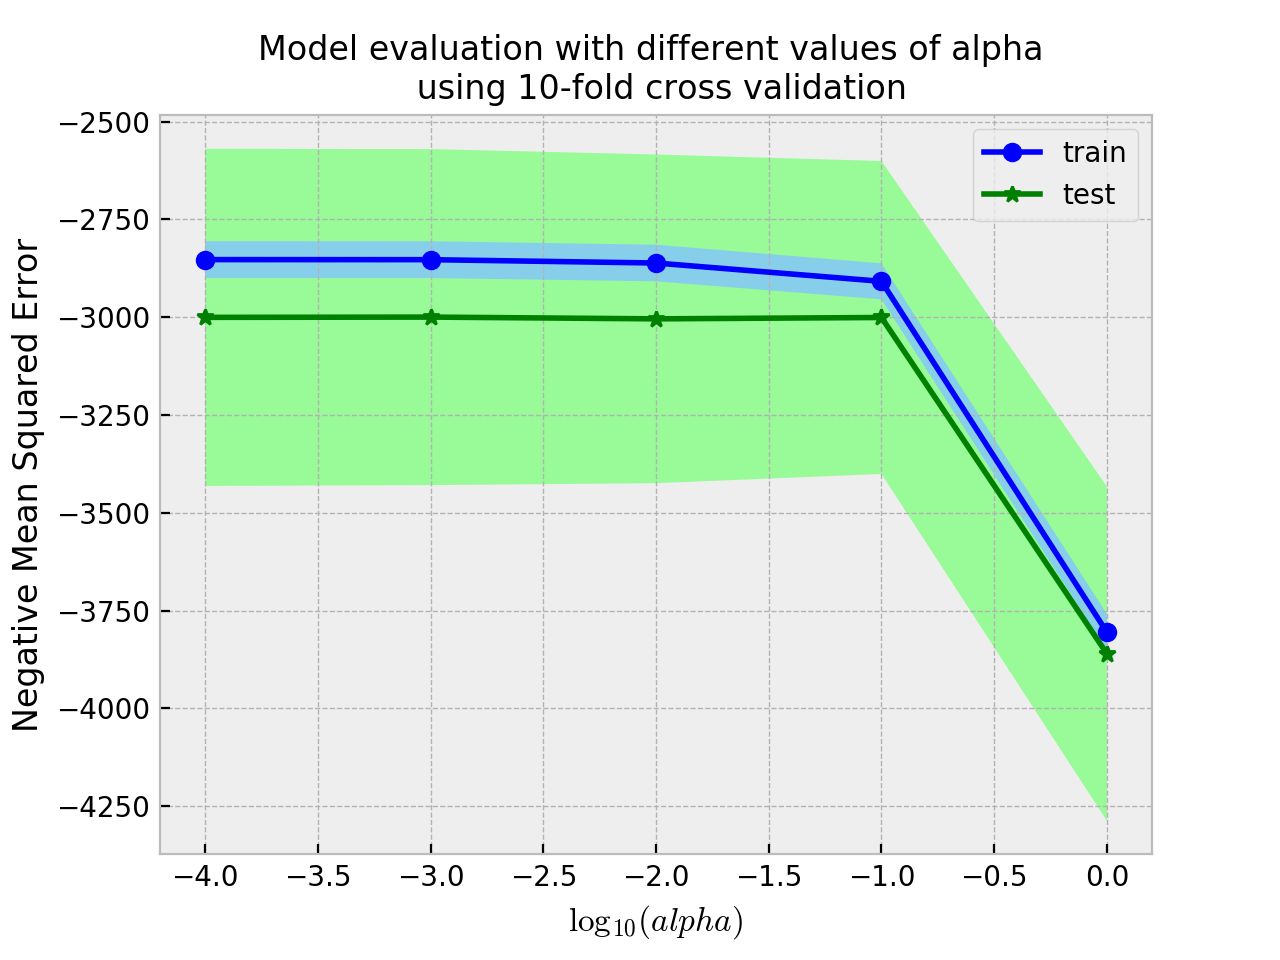

In [13]:
plt.style.use('bmh')
plt.figure()
plt.plot(param_range, train_means, 'bo-', label = "train")
plt.plot(param_range, test_means, 'g*-', label = "test")
plt.xlabel('$\log_{10} (alpha)$', fontsize ='large')
plt.ylabel('Negative Mean Squared Error', fontsize = 'large')
plt.title('Model evaluation with different values of alpha \n using 10-fold cross validation', 
          fontsize = 'large')
plt.legend()
plt.fill_between(x = param_range, y1 = test_means + (2/np.sqrt(10)) * test_sd, 
                 y2 = test_means - (2/np.sqrt(10)) * test_sd, 
                facecolor = 'palegreen')
plt.fill_between(x = param_range, y1 = train_means + (2/np.sqrt(10)) * train_sd, 
                                  y2 = train_means - (2/np.sqrt(10)) * train_sd, 
                facecolor = 'skyblue')

##### 4.3 Multiple metric evaluation using cross_validate function
- cross validate allows passing of multiple metrics as a list or a dictionary among other ways 
- allows evaluation of metrics (called scorers - misnomer i think, coz act of scoring is different, independent
 of eval metric, and just about generation prediction) on each training and test fold, which 
  can be used to gain insight into overfit / underfit performance 
- allows returning of training times (aka fit times),scoring times(only on test folds), and scored metrics 
  on each train and test folds by returning a dictionary with keys as test_<eval_metric>, train_<eval_metric>,
  and values as arrays equal to length of cv


###### Stratified sampling using train_test_split, cv is used on train to estimate performancer of model, a final benchmark is taken on test set

In [134]:
from sklearn.model_selection import cross_validate, train_test_split
from sklearn.neighbors import KNeighborsClassifier
iris = datasets.load_iris()
y = iris.target
X = iris.data
X_train, X_test = train_test_split(X, test_size = 0.2, random_state = 123, stratify = y)
y_train, y_test = train_test_split(y, test_size = 0.2, random_state = 123, stratify = y)
y_0 = sum(y == 0)
y_1 = sum(y == 1)
y_2 = sum(y == 2)

y_0_train = sum(y_train == 0)
y_1_train = sum(y_train == 1)
y_2_train = sum(y_train == 2)
y_0_test = sum(y_test == 0)
y_1_test = sum(y_test == 1)
y_2_test = sum(y_test == 2)
print('Props. of 0, y : {0:.2f}, y_train : {1:.2f}, y_test : {2:.2f}'.format(y_0/len(y),
                                                         y_0_train/len(y_train),y_0_test/len(y_test)))
print('Props. of 1, y : {0:.2f}, y_train : {1:.2f}, y_test : {2:.2f}'.format(y_1/len(y),
                                                         y_1_train/len(y_train),y_1_test/len(y_test)))
print('Props. of 2, y : {0:.2f}, y_train : {1:.2f}, y_test : {2:.2f}'.format(y_0/len(y),
                                                         y_2_train/len(y_train),y_2_test/len(y_test)))

Props. of 0, y : 0.33, y_train : 0.33, y_test : 0.33
Props. of 1, y : 0.33, y_train : 0.33, y_test : 0.33
Props. of 2, y : 0.33, y_train : 0.33, y_test : 0.33


##### Create multiple eval metrics, invoke classifier, and use cross_validate

In [135]:
from sklearn.metrics import f1_score , make_scorer
clf = KNeighborsClassifier(n_neighbors = 3)
scoring_params = {'f1_macro' : make_scorer(score_func = f1_score,
                                           greater_is_better= True,
                                           average = 'macro'),
                 'f1_micro' : make_scorer(score_func = f1_score,
                                           greater_is_better= True,
                                           average = 'micro'),
                 'f1_weighted' : make_scorer(score_func = f1_score,
                                           greater_is_better= True,
                                           average = 'weighted')}
# not sure if shuffle is performed here
cv_scores = cross_validate(estimator= clf, X = X_train, y = y_train, 
               scoring = scoring_params, cv = 10, return_train_score = True )

In [136]:
cv_scores.keys()

dict_keys(['fit_time', 'score_time', 'test_f1_macro', 'train_f1_macro', 'test_f1_micro', 'train_f1_micro', 'test_f1_weighted', 'train_f1_weighted'])

In [137]:
#print(cv_scores['fit_time'])
#print(cv_scores['score_time'])

##### Bar plot of train and test scores, with error bars

<IPython.core.display.Javascript object>


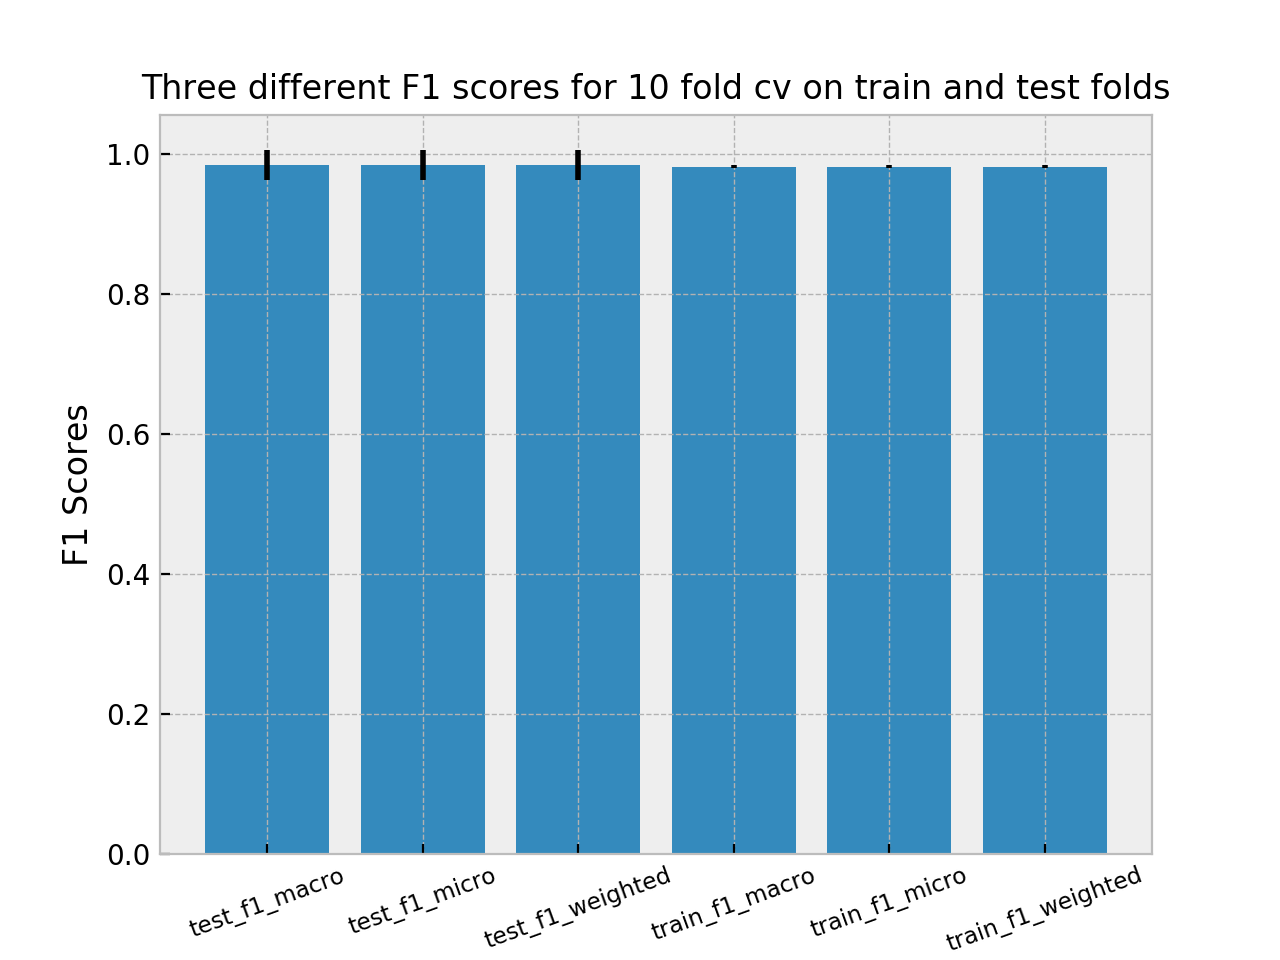

Text(0.5,1,'Three different F1 scores for 10 fold cv on train and test folds')

In [138]:
plt.style.use('bmh')
plt.figure()
x = ['test_f1_macro', 'train_f1_macro', 'test_f1_micro', 'train_f1_micro', 
             'test_f1_weighted', 'train_f1_weighted']
heights = [np.mean(cv_scores[i]) for i in x]
std_err = [2*np.std(cv_scores[i])/np.sqrt(10) for i in x]
bars = plt.bar(x = x, height = heights, yerr = std_err)
plt.xticks(rotation = 20,fontsize = 'small')
plt.ylabel('F1 Scores')
plt.title('Three different F1 scores for 10 fold cv on train and test folds', fontsize = 'large')

#### 5. Use of cross validation for model blending : cv_val_predict
- cv_val_predict returns the predictions on each of the test folds made during cross validation 
- so, returns an array of length same as the length of X_train or y_train 
- valid for cross validation strategies that assign each record to only one cv test fold 
- Useful for : 
  - Model Blending : When predictions from a supervised model are used by another model as a feature
  Eg: 3 folds created. First fold used to fit a supervised model using non-linear model - say m1, and generate a score 
  on fold 2. A linear model trained on fold 2 -say m2, performance evaluated using a cv on this fold.
  Final evaluation is done on fold 3, after scoring it using m1, then m2 
  - Analyzing predictions vs actuals. Every example gets prediction score from one model, as well as training 
    score from n-1 models


#### 6. Different Iterators for cross validation 
IID samples are important assumption in machine learning. Samples are assumed to come from same process,
and independent i.e generative process does not have memory of past generated samples. 
The assumption is violated in case time series data, and if data generated from groups - like experiments 
on groups of people, from group of devices etc.
Time series CV, and group wise CV strategies are more apt there.

#### 6.1 Regression task (iid data)
- Kfold
- Repeated Kfold : When you want to overcome the chance of how split ocuurs with a k fold cv, repeat it n times
- Leave one out (LOO)
- Leave p out
- Random permutations cv / Shuffle and Split  

In [139]:
# Kfold - obtain indices for each iteration of cv
from sklearn.model_selection import KFold
X = np.array([[1,2], [3,4],[5,6], [7,8], [9,10], [11,12]])
y = np.array([1,2,3,4,5,6])
kf = KFold(n_splits= 3, random_state= 123, shuffle = True)
for train_idx, test_idx in kf.split(X):
    X_train, X_test = X[train_idx], X[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]
    print('--CV--')
    print('X_train :\n', X_train, '\n X_test \n:',X_test)
    print('\n y_train :', y_train, '\n y_test :',y_test)

--CV--
X_train :
 [[ 1  2]
 [ 5  6]
 [ 9 10]
 [11 12]] 
 X_test 
: [[3 4]
 [7 8]]

 y_train : [1 3 5 6] 
 y_test : [2 4]
--CV--
X_train :
 [[ 3  4]
 [ 5  6]
 [ 7  8]
 [11 12]] 
 X_test 
: [[ 1  2]
 [ 9 10]]

 y_train : [2 3 4 6] 
 y_test : [1 5]
--CV--
X_train :
 [[ 1  2]
 [ 3  4]
 [ 7  8]
 [ 9 10]] 
 X_test 
: [[ 5  6]
 [11 12]]

 y_train : [1 2 4 5] 
 y_test : [3 6]


In [141]:
# Repeated  k fold , does not have shuffle argument
from sklearn.model_selection import RepeatedKFold
rkf = RepeatedKFold(n_splits= 3, n_repeats= 2,random_state= 123)
for train_idx, test_idx in rkf.split(X):
    X_train, X_test = X[train_idx], X[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]
    print('--CV--')
    print('X_train :\n', X_train, '\n X_test \n:',X_test)
    print('\n y_train :', y_train, '\n y_test :',y_test)

--CV--
X_train :
 [[ 1  2]
 [ 5  6]
 [ 9 10]
 [11 12]] 
 X_test 
: [[3 4]
 [7 8]]

 y_train : [1 3 5 6] 
 y_test : [2 4]
--CV--
X_train :
 [[ 3  4]
 [ 5  6]
 [ 7  8]
 [11 12]] 
 X_test 
: [[ 1  2]
 [ 9 10]]

 y_train : [2 3 4 6] 
 y_test : [1 5]
--CV--
X_train :
 [[ 1  2]
 [ 3  4]
 [ 7  8]
 [ 9 10]] 
 X_test 
: [[ 5  6]
 [11 12]]

 y_train : [1 2 4 5] 
 y_test : [3 6]
--CV--
X_train :
 [[ 3  4]
 [ 5  6]
 [ 7  8]
 [11 12]] 
 X_test 
: [[ 1  2]
 [ 9 10]]

 y_train : [2 3 4 6] 
 y_test : [1 5]
--CV--
X_train :
 [[ 1  2]
 [ 3  4]
 [ 7  8]
 [ 9 10]] 
 X_test 
: [[ 5  6]
 [11 12]]

 y_train : [1 2 4 5] 
 y_test : [3 6]
--CV--
X_train :
 [[ 1  2]
 [ 5  6]
 [ 9 10]
 [11 12]] 
 X_test 
: [[3 4]
 [7 8]]

 y_train : [1 3 5 6] 
 y_test : [2 4]


In [98]:
# LOO 
#### LOO is akin to cross validation using k as n.It has been shown to have low bias in estimating performance
#### (because all models are alike) but high variance, and are computationaly extensive also. They do well
#### in allowing more data to be used for training when samples are less
from sklearn.model_selection import LeaveOneOut as LOO

# Leave p out 
#### It is more expensive version of LOO, as nCp train test sets can be created. 
#### Each sample gets score more than once , unlike in k-fold CV 
#### This technique is supposed to be better than LOO for small samples
from sklearn.model_selection import LeavePOut

In [100]:
# Shuffle Split
#### Allows specifying the no. of train/test pairs to be created from the data, and train/test size.
#### Data is shuffled first, and then split baed on test/train_size, n_splits times
#### In k fold, test size if 1/cv
#### So, each sample may get scored more than once, and not all samples are necessarily used for training
from sklearn.model_selection import ShuffleSplit
ss = ShuffleSplit(n_splits=10, test_size= 0.25, random_state= 123)

#### 6.2 Classification task (iid data) 
To preserve the relative proportions of labels of target in folds, these classes are available
- Stratified Kfold
- Repeated Stratified Kfold
- Stratified Shuffle Split

#### 6.3 CV iterators for grouped data
- Group k -fold
- Leave one group out
- Leave p groups out
- Group shuffle split

In [105]:
# Group k fold
### Examples like modeling losses at vehicle level. There could be several vehicles on a policy, so 
### a good cv strategy will be to meausre test error on vehciles from policies that were not used for training
### Other examples : If multiple readings take from same parents, you want to split by groups, to keep data from 
### unseen patients in the test sets of each train/test pair in cv
### Folds are approx. balanced, not exactly balanced
from sklearn.model_selection import GroupKFold
X = np.array([[1, 2], [3, 4], [5, 6], [7, 8]])
y = np.array([1, 2, 3, 4])
groups = np.array([0, 0, 2, 2])
gkf = GroupKFold(n_splits= 2)
for train_ind, test_ind in gkf.split(X,y,groups):
    print(train_ind, test_ind)

[0 1] [2 3]
[2 3] [0 1]


In [ ]:
# Leave one/p group out 
## - The usefulness of this approach could be thought for a time based cross validation, or geo based cross validation 
## when across time or across geo based samples are being used under an assumption that they are IID. You could get a
## generaliation error estimate by marking each geo or time sample to a group, and using this cv strategy

In [107]:
# Group Shuffle Split 
## This approach is an alternative to grouped k fold, it allows to draw multiple train test splits by groups,
## in the proportions that work on groups, and not directly on samples. 
from sklearn.model_selection import GroupShuffleSplit 
X = [0.1, 0.2, 2.2, 2.4, 2.3, 4.55, 5.8, 0.001]
y = ["a", "b", "b", "b", "c", "c", "c", "a"]
groups = [1, 1, 2, 2, 3, 3, 4, 4]
gss = GroupShuffleSplit(n_splits= 3, test_size= 0.25, random_state= 123)
for train_ind, test_ind in gss.split(X,y,groups):
    print(train_ind, test_ind)

[0 1 2 3 4 5] [6 7]
[0 1 4 5 6 7] [2 3]
[2 3 4 5 6 7] [0 1]


#### 6.4 Other strategies
- pre defined split
- cv for time series
- notes on shuffling

In [111]:
# Pre defined split 
## Class PreDefinedSplit allow to use an array that indicates predefined splits for each samples to 
## a test set. This allow for multiple train/test sets to be created by using this array
X = np.array([[1, 2], [3, 4], [1, 2], [3, 4]])
y = np.array([0, 0, 1, 1])
test_fold = [0, 1, -1, 1]
from sklearn.model_selection import PredefinedSplit
pds = PredefinedSplit(test_fold)
for train_idx, test_idx in pds.split(): # does not take any argument,just generates indices
    # -1 ndicates the index not be put into any test set
    print(train_idx, test_idx)

[1 2 3] [0]
[0 2] [1 3]


In [127]:
# cv for time series
## idea is to select multiple test/train split to get an estimate of model performance
## test to a training pair should be later in time 
## TimeSeriesSplit provides one way to do splits
from sklearn.model_selection import TimeSeriesSplit
X = np.array([[11, 12], [3, 4], [1, 2], [5, 6]])
y = np.array([1, 2, 3, 4])
tss = TimeSeriesSplit(n_splits = 3)
for train_idx, test_idx in tss.split(X): 
    #print(train_idx, test_idx)
    X_train, X_test = X[train_idx], X[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]
    print('X_train :\n', X_train, '\nX_test :\n',X_test, '\n')
    print('y_train',y_train,'y_test', y_test)

X_train :
 [[11 12]] 
X_test :
 [[3 4]] 

y_train [1] y_test [2]
X_train :
 [[11 12]
 [ 3  4]] 
X_test :
 [[1 2]] 

y_train [1 2] y_test [3]
X_train :
 [[11 12]
 [ 3  4]
 [ 1  2]] 
X_test :
 [[5 6]] 

y_train [1 2 3] y_test [4]


#### Shuffling - Mostly to be aware of 
- Unless sequence of the data is important ,or shuffling would be a time sensitive operation, shuffling should be
 performed before splitting to ensure contiguous samples put into data do not go into train and test sets
- sequence is important to maintain in time series, or in cases like when we are training on news articles written over a period of time, and would want to obtain a generalization of estimator performance on future articles  
- So, it is important to determine if shuffle is desirable for measuring performance. In some cases, not shuffling 
  can cause overfitting 
- **Not all cv iterators perform shuffle before splitting, and some iterators might be performing a sequential 
  k fold split, which might not be good (like cross_val_score, cross_val_predict, validation_curve,cross_validate may   not perform shuffle is cv is passed an int value)**
- Kfold has an option shuffle as do some other cross validation iterators, the shuffle operation is faster 
  and should be preferred to use
- **To fix a shuffle operation, use random_state argument where available**
- **The argument cv in methods - cross_val_score, cross_val_predict, validation_curve,cross_validate, can take
  a cross validation object, so create the object with shuffle on, and pass to cv argument to ensure shuffle is on**
      